<a href="https://colab.research.google.com/github/ivahnenkoA/nuclear_reactor/blob/main/Radius_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants
import time as time

In [ ]:
neutrons_number = 5000
height = 6000  # reactor height in cm, kept constant in this simulation
radius = 45  # starting reactor radius, cm
radius_step = 5  # reactor radius increment, cm
trials = 50  # number of radius trials

In [ ]:
Na = scipy.constants.Avogadro # avogadro's number
Barn = 10**-24 # barns in cm^-2
v = 2.42

U_density = 18.9 *(1/300)
C_density = 1.67 *(299/300)
U235_Mr = 235 # 238.02891
U238_Mr = 238
C_Mr = 12
U235_p = 0.725*0.01 # concentration of uranium 235
U238_p = 1-U235_p

U235_c = 101 # microscopic cross section of capture of uranium  in barns
U238_c = 2.72
C_c    = 0.0035
U235_f = 579 # fission
U235_s = 10  # scattering
U238_s = 8.3
C_s    = 5.551


U235_Ec = (U_density * U235_p * U235_c * Barn * Na)/(U235_Mr) # macroscopic cross section of capture of 235
U238_Ec = (U_density * U238_p * U238_c * Barn * Na)/(U238_Mr)
C_Ec    = (C_density * C_c * Barn * Na)/(C_Mr)
U235_Ef = (U_density * U235_p * U235_f * Barn * Na)/(U235_Mr) # fission
U235_Es = (U_density * U235_p * U235_s * Barn * Na)/(U235_Mr) # scattering
U238_Es = (U_density * U238_p * U238_s * Barn * Na)/(U238_Mr)
C_Es    = (C_density * C_s * Barn * Na)/(C_Mr)

Ec = U235_Ec + U238_Ec + C_Ec
Ef = U235_Ef
Es = U235_Es + U238_Es + C_Es
Et = Ec+Ef+Es
lamb = 1/Et

p_a = (Ef+Ec)/Et
p_f = Ef/(Ef+Ec)

v_eff = v*p_f


In [ ]:
def scatter(N, H, R):

    theta = np.random.uniform(0,2*np.pi, N)
    rad = np.random.uniform(0, R**2, N)
    X = np.sqrt(rad)*np.cos(theta)
    Y = np.sqrt(rad)*np.sin(theta)
    Z = np.random.uniform(0, H, N)
    return X,Y,Z

In [ ]:
def central_scatter(N,H):

    z = np.random.uniform(0,H,N)
    x=0
    y=0

    return x,y,z

In [ ]:
def random_direction():
    theta = np.random.uniform(0, 2*np.pi, 1)
    r = np.random.uniform(0, 1, 1)
    phi = np.arccos(2*r-1)
    return theta, phi

In [ ]:
def random_length(lamb):
    r = np.random.uniform(0,1,1)
    d = -lamb*np.log(r)
    return d

In [ ]:
def outcome_decider(p):
    r = np.random.uniform(0,1,1)
    if r <= p :
        return True
    else :
        return False

In [ ]:
def random_motion(lamb,pos):
    L = random_length(lamb)
    theta, phi = random_direction()

    pos[0] = pos[0] + L*np.cos(theta)*np.sin(phi)
    pos[1] = pos[1] + L*np.sin(theta)*np.sin(phi)
    pos[2] = pos[2] + L*np.cos(phi)
    return pos

In [ ]:
def resolution(pos):
    stopped = False


    result = np.array([0,0,0,0]) # escaped,bounced,captured, v_eff
    while stopped == False:


        pos = random_motion(lamb,pos)


        if (pos[0]**2 + pos[1]**2 < radius**2  and pos[2]>0 and pos[2]<height) == False:
            stopped = True
            result = result + [1,0,0,0]
        elif outcome_decider(p_a) == True :
            result = result + [0,0,1,v_eff]
            stopped = True
        else:
            result = result + [0,1,0,0]

    return result, pos

In [ ]:
def resampler(absorbed):
    posistion = np.zeros((iterations,3))
    for i in range(iterations):
        j = np.random.randint(0,len(absorbed))
        posistion[i] = absorbed[j]
    return posistion

In [ ]:

iteration = 0
trial = 0

escaped_total = np.empty((1,100))
absorb_total = np.empty((1,100))
radius_total = np.empty((1,100))
height_total = np.empty((1,100))
k_total = np.empty((1,100))


In [ ]:
for k in range(trials):
    radius = radius + radius_step
    print('\n\nHeight : {}    Radius : {}'.format(height, radius))
    trial = trial + 1

    k_array = []
    escaped_array = []
    absorb_counter = []
    radius_array = []
    height_array = []
    result_array = np.zeros((neutrons_number,4)) # escaped,bounced,absorbed, v_eff
    iteration = 0
    iterations = 100

    x,y,z = scatter(neutrons_number, height, radius)
    posistion_array = np.column_stack((x,y,z))

    for j in range(iterations):

        absorbed_array = np.empty((0,3))

        for i in range(neutrons_number):

            result, temp = resolution(posistion_array[i])
            result_array[i] = result

            if result[2] == 1:
                absorbed_array = np.vstack((absorbed_array, temp))

        split = np.hsplit(result_array,4)

        k = np.sum(split[3])/neutrons_number
        iteration = iteration + 1
        print("\nTrial : {0}    Iteration : {1}".format(trial, iteration))
        print("K value : {0:4.3f}    Escaped : {1}    Absorbed : {2}    ".format(k, np.sum(split[0]), np.sum(split[2])))


        k_array = np.append(k_array, k)
        escaped_array = np.append(escaped_array, np.sum(split[0]))
        absorb_counter = np.append(absorb_counter, np.sum(split[2]))
        radius_array = np.append(radius_array, radius)
        height_array = np.append(height_array, height)


        posistion_array = resampler(absorbed_array)

    escaped_total = np.vstack((escaped_total, escaped_array))
    absorb_total = np.vstack((absorb_total, absorb_counter))
    radius_total = np.vstack((radius_total, radius_array))
    height_total = np.vstack((height_total, height_array))
    k_total = np.vstack((k_total, k_array))




Height : 6000    Radius : 50

Trial : 1    Iteration : 1
K value : 0.470    Escaped : 2825.0    Absorbed : 2175.0    

Trial : 1    Iteration : 2
K value : 0.506    Escaped : 2658.0    Absorbed : 2342.0    

Trial : 1    Iteration : 3
K value : 0.529    Escaped : 2552.0    Absorbed : 2448.0    

Trial : 1    Iteration : 4
K value : 0.543    Escaped : 2487.0    Absorbed : 2513.0    

Trial : 1    Iteration : 5
K value : 0.536    Escaped : 2518.0    Absorbed : 2482.0    

Trial : 1    Iteration : 6
K value : 0.543    Escaped : 2485.0    Absorbed : 2515.0    

Trial : 1    Iteration : 7
K value : 0.534    Escaped : 2528.0    Absorbed : 2472.0    

Trial : 1    Iteration : 8
K value : 0.548    Escaped : 2461.0    Absorbed : 2539.0    

Trial : 1    Iteration : 9
K value : 0.536    Escaped : 2516.0    Absorbed : 2484.0    

Trial : 1    Iteration : 10
K value : 0.538    Escaped : 2509.0    Absorbed : 2491.0    

Trial : 1    Iteration : 11
K value : 0.543    Escaped : 2487.0    Absorbed :


Trial : 1    Iteration : 92
K value : 0.537    Escaped : 2514.0    Absorbed : 2486.0    

Trial : 1    Iteration : 93
K value : 0.525    Escaped : 2569.0    Absorbed : 2431.0    

Trial : 1    Iteration : 94
K value : 0.533    Escaped : 2530.0    Absorbed : 2470.0    

Trial : 1    Iteration : 95
K value : 0.532    Escaped : 2539.0    Absorbed : 2461.0    

Trial : 1    Iteration : 96
K value : 0.537    Escaped : 2513.0    Absorbed : 2487.0    

Trial : 1    Iteration : 97
K value : 0.537    Escaped : 2515.0    Absorbed : 2485.0    

Trial : 1    Iteration : 98
K value : 0.543    Escaped : 2487.0    Absorbed : 2513.0    

Trial : 1    Iteration : 99
K value : 0.541    Escaped : 2496.0    Absorbed : 2504.0    

Trial : 1    Iteration : 100
K value : 0.521    Escaped : 2587.0    Absorbed : 2413.0    


Height : 6000    Radius : 55

Trial : 2    Iteration : 1
K value : 0.627    Escaped : 2099.0    Absorbed : 2901.0    

Trial : 2    Iteration : 2
K value : 0.593    Escaped : 2253.0    Ab


Trial : 2    Iteration : 83
K value : 0.587    Escaped : 2281.0    Absorbed : 2719.0    

Trial : 2    Iteration : 84
K value : 0.573    Escaped : 2347.0    Absorbed : 2653.0    

Trial : 2    Iteration : 85
K value : 0.573    Escaped : 2348.0    Absorbed : 2652.0    

Trial : 2    Iteration : 86
K value : 0.565    Escaped : 2386.0    Absorbed : 2614.0    

Trial : 2    Iteration : 87
K value : 0.581    Escaped : 2309.0    Absorbed : 2691.0    

Trial : 2    Iteration : 88
K value : 0.599    Escaped : 2228.0    Absorbed : 2772.0    

Trial : 2    Iteration : 89
K value : 0.577    Escaped : 2330.0    Absorbed : 2670.0    

Trial : 2    Iteration : 90
K value : 0.572    Escaped : 2353.0    Absorbed : 2647.0    

Trial : 2    Iteration : 91
K value : 0.595    Escaped : 2244.0    Absorbed : 2756.0    

Trial : 2    Iteration : 92
K value : 0.584    Escaped : 2294.0    Absorbed : 2706.0    

Trial : 2    Iteration : 93
K value : 0.578    Escaped : 2323.0    Absorbed : 2677.0    

Trial : 2


Trial : 3    Iteration : 74
K value : 0.647    Escaped : 2002.0    Absorbed : 2998.0    

Trial : 3    Iteration : 75
K value : 0.625    Escaped : 2105.0    Absorbed : 2895.0    

Trial : 3    Iteration : 76
K value : 0.632    Escaped : 2074.0    Absorbed : 2926.0    

Trial : 3    Iteration : 77
K value : 0.627    Escaped : 2099.0    Absorbed : 2901.0    

Trial : 3    Iteration : 78
K value : 0.630    Escaped : 2084.0    Absorbed : 2916.0    

Trial : 3    Iteration : 79
K value : 0.620    Escaped : 2131.0    Absorbed : 2869.0    

Trial : 3    Iteration : 80
K value : 0.625    Escaped : 2106.0    Absorbed : 2894.0    

Trial : 3    Iteration : 81
K value : 0.637    Escaped : 2051.0    Absorbed : 2949.0    

Trial : 3    Iteration : 82
K value : 0.626    Escaped : 2103.0    Absorbed : 2897.0    

Trial : 3    Iteration : 83
K value : 0.624    Escaped : 2110.0    Absorbed : 2890.0    

Trial : 3    Iteration : 84
K value : 0.637    Escaped : 2051.0    Absorbed : 2949.0    

Trial : 3


Trial : 4    Iteration : 65
K value : 0.683    Escaped : 1839.0    Absorbed : 3161.0    

Trial : 4    Iteration : 66
K value : 0.677    Escaped : 1867.0    Absorbed : 3133.0    

Trial : 4    Iteration : 67
K value : 0.667    Escaped : 1912.0    Absorbed : 3088.0    

Trial : 4    Iteration : 68
K value : 0.669    Escaped : 1901.0    Absorbed : 3099.0    

Trial : 4    Iteration : 69
K value : 0.661    Escaped : 1939.0    Absorbed : 3061.0    

Trial : 4    Iteration : 70
K value : 0.691    Escaped : 1800.0    Absorbed : 3200.0    

Trial : 4    Iteration : 71
K value : 0.669    Escaped : 1901.0    Absorbed : 3099.0    

Trial : 4    Iteration : 72
K value : 0.666    Escaped : 1915.0    Absorbed : 3085.0    

Trial : 4    Iteration : 73
K value : 0.673    Escaped : 1882.0    Absorbed : 3118.0    

Trial : 4    Iteration : 74
K value : 0.656    Escaped : 1963.0    Absorbed : 3037.0    

Trial : 4    Iteration : 75
K value : 0.674    Escaped : 1877.0    Absorbed : 3123.0    

Trial : 4


Trial : 5    Iteration : 56
K value : 0.709    Escaped : 1718.0    Absorbed : 3282.0    

Trial : 5    Iteration : 57
K value : 0.701    Escaped : 1752.0    Absorbed : 3248.0    

Trial : 5    Iteration : 58
K value : 0.702    Escaped : 1748.0    Absorbed : 3252.0    

Trial : 5    Iteration : 59
K value : 0.711    Escaped : 1707.0    Absorbed : 3293.0    

Trial : 5    Iteration : 60
K value : 0.704    Escaped : 1739.0    Absorbed : 3261.0    

Trial : 5    Iteration : 61
K value : 0.696    Escaped : 1779.0    Absorbed : 3221.0    

Trial : 5    Iteration : 62
K value : 0.707    Escaped : 1727.0    Absorbed : 3273.0    

Trial : 5    Iteration : 63
K value : 0.702    Escaped : 1748.0    Absorbed : 3252.0    

Trial : 5    Iteration : 64
K value : 0.699    Escaped : 1763.0    Absorbed : 3237.0    

Trial : 5    Iteration : 65
K value : 0.705    Escaped : 1734.0    Absorbed : 3266.0    

Trial : 5    Iteration : 66
K value : 0.714    Escaped : 1695.0    Absorbed : 3305.0    

Trial : 5


Trial : 6    Iteration : 47
K value : 0.736    Escaped : 1594.0    Absorbed : 3406.0    

Trial : 6    Iteration : 48
K value : 0.748    Escaped : 1535.0    Absorbed : 3465.0    

Trial : 6    Iteration : 49
K value : 0.726    Escaped : 1640.0    Absorbed : 3360.0    

Trial : 6    Iteration : 50
K value : 0.735    Escaped : 1596.0    Absorbed : 3404.0    

Trial : 6    Iteration : 51
K value : 0.733    Escaped : 1608.0    Absorbed : 3392.0    

Trial : 6    Iteration : 52
K value : 0.728    Escaped : 1627.0    Absorbed : 3373.0    

Trial : 6    Iteration : 53
K value : 0.725    Escaped : 1644.0    Absorbed : 3356.0    

Trial : 6    Iteration : 54
K value : 0.737    Escaped : 1589.0    Absorbed : 3411.0    

Trial : 6    Iteration : 55
K value : 0.741    Escaped : 1570.0    Absorbed : 3430.0    

Trial : 6    Iteration : 56
K value : 0.738    Escaped : 1584.0    Absorbed : 3416.0    

Trial : 6    Iteration : 57
K value : 0.735    Escaped : 1599.0    Absorbed : 3401.0    

Trial : 6


Trial : 7    Iteration : 38
K value : 0.769    Escaped : 1440.0    Absorbed : 3560.0    

Trial : 7    Iteration : 39
K value : 0.757    Escaped : 1496.0    Absorbed : 3504.0    

Trial : 7    Iteration : 40
K value : 0.767    Escaped : 1448.0    Absorbed : 3552.0    

Trial : 7    Iteration : 41
K value : 0.775    Escaped : 1410.0    Absorbed : 3590.0    

Trial : 7    Iteration : 42
K value : 0.771    Escaped : 1429.0    Absorbed : 3571.0    

Trial : 7    Iteration : 43
K value : 0.776    Escaped : 1408.0    Absorbed : 3592.0    

Trial : 7    Iteration : 44
K value : 0.773    Escaped : 1420.0    Absorbed : 3580.0    

Trial : 7    Iteration : 45
K value : 0.767    Escaped : 1450.0    Absorbed : 3550.0    

Trial : 7    Iteration : 46
K value : 0.761    Escaped : 1476.0    Absorbed : 3524.0    

Trial : 7    Iteration : 47
K value : 0.770    Escaped : 1435.0    Absorbed : 3565.0    

Trial : 7    Iteration : 48
K value : 0.755    Escaped : 1506.0    Absorbed : 3494.0    

Trial : 7


Trial : 8    Iteration : 29
K value : 0.784    Escaped : 1369.0    Absorbed : 3631.0    

Trial : 8    Iteration : 30
K value : 0.792    Escaped : 1334.0    Absorbed : 3666.0    

Trial : 8    Iteration : 31
K value : 0.796    Escaped : 1313.0    Absorbed : 3687.0    

Trial : 8    Iteration : 32
K value : 0.789    Escaped : 1346.0    Absorbed : 3654.0    

Trial : 8    Iteration : 33
K value : 0.788    Escaped : 1353.0    Absorbed : 3647.0    

Trial : 8    Iteration : 34
K value : 0.782    Escaped : 1377.0    Absorbed : 3623.0    

Trial : 8    Iteration : 35
K value : 0.794    Escaped : 1324.0    Absorbed : 3676.0    

Trial : 8    Iteration : 36
K value : 0.789    Escaped : 1347.0    Absorbed : 3653.0    

Trial : 8    Iteration : 37
K value : 0.794    Escaped : 1324.0    Absorbed : 3676.0    

Trial : 8    Iteration : 38
K value : 0.787    Escaped : 1356.0    Absorbed : 3644.0    

Trial : 8    Iteration : 39
K value : 0.780    Escaped : 1389.0    Absorbed : 3611.0    

Trial : 8


Trial : 9    Iteration : 20
K value : 0.833    Escaped : 1141.0    Absorbed : 3859.0    

Trial : 9    Iteration : 21
K value : 0.816    Escaped : 1222.0    Absorbed : 3778.0    

Trial : 9    Iteration : 22
K value : 0.812    Escaped : 1242.0    Absorbed : 3758.0    

Trial : 9    Iteration : 23
K value : 0.814    Escaped : 1229.0    Absorbed : 3771.0    

Trial : 9    Iteration : 24
K value : 0.825    Escaped : 1178.0    Absorbed : 3822.0    

Trial : 9    Iteration : 25
K value : 0.822    Escaped : 1194.0    Absorbed : 3806.0    

Trial : 9    Iteration : 26
K value : 0.810    Escaped : 1249.0    Absorbed : 3751.0    

Trial : 9    Iteration : 27
K value : 0.817    Escaped : 1216.0    Absorbed : 3784.0    

Trial : 9    Iteration : 28
K value : 0.807    Escaped : 1265.0    Absorbed : 3735.0    

Trial : 9    Iteration : 29
K value : 0.815    Escaped : 1225.0    Absorbed : 3775.0    

Trial : 9    Iteration : 30
K value : 0.813    Escaped : 1238.0    Absorbed : 3762.0    

Trial : 9


Trial : 10    Iteration : 11
K value : 0.831    Escaped : 1152.0    Absorbed : 3848.0    

Trial : 10    Iteration : 12
K value : 0.830    Escaped : 1159.0    Absorbed : 3841.0    

Trial : 10    Iteration : 13
K value : 0.831    Escaped : 1153.0    Absorbed : 3847.0    

Trial : 10    Iteration : 14
K value : 0.843    Escaped : 1098.0    Absorbed : 3902.0    

Trial : 10    Iteration : 15
K value : 0.828    Escaped : 1165.0    Absorbed : 3835.0    

Trial : 10    Iteration : 16
K value : 0.858    Escaped : 1029.0    Absorbed : 3971.0    

Trial : 10    Iteration : 17
K value : 0.840    Escaped : 1113.0    Absorbed : 3887.0    

Trial : 10    Iteration : 18
K value : 0.841    Escaped : 1107.0    Absorbed : 3893.0    

Trial : 10    Iteration : 19
K value : 0.834    Escaped : 1139.0    Absorbed : 3861.0    

Trial : 10    Iteration : 20
K value : 0.819    Escaped : 1210.0    Absorbed : 3790.0    

Trial : 10    Iteration : 21
K value : 0.826    Escaped : 1177.0    Absorbed : 3823.0    


Trial : 11    Iteration : 1
K value : 0.888    Escaped : 890.0    Absorbed : 4110.0    

Trial : 11    Iteration : 2
K value : 0.869    Escaped : 977.0    Absorbed : 4023.0    

Trial : 11    Iteration : 3
K value : 0.859    Escaped : 1022.0    Absorbed : 3978.0    

Trial : 11    Iteration : 4
K value : 0.862    Escaped : 1011.0    Absorbed : 3989.0    

Trial : 11    Iteration : 5
K value : 0.868    Escaped : 983.0    Absorbed : 4017.0    

Trial : 11    Iteration : 6
K value : 0.864    Escaped : 1001.0    Absorbed : 3999.0    

Trial : 11    Iteration : 7
K value : 0.851    Escaped : 1060.0    Absorbed : 3940.0    

Trial : 11    Iteration : 8
K value : 0.856    Escaped : 1037.0    Absorbed : 3963.0    

Trial : 11    Iteration : 9
K value : 0.848    Escaped : 1073.0    Absorbed : 3927.0    

Trial : 11    Iteration : 10
K value : 0.849    Escaped : 1071.0    Absorbed : 3929.0    

Trial : 11    Iteration : 11
K value : 0.855    Escaped : 1042.0    Absorbed : 3958.0    

Trial : 11


Trial : 11    Iteration : 92
K value : 0.856    Escaped : 1035.0    Absorbed : 3965.0    

Trial : 11    Iteration : 93
K value : 0.859    Escaped : 1025.0    Absorbed : 3975.0    

Trial : 11    Iteration : 94
K value : 0.844    Escaped : 1094.0    Absorbed : 3906.0    

Trial : 11    Iteration : 95
K value : 0.859    Escaped : 1024.0    Absorbed : 3976.0    

Trial : 11    Iteration : 96
K value : 0.861    Escaped : 1012.0    Absorbed : 3988.0    

Trial : 11    Iteration : 97
K value : 0.847    Escaped : 1076.0    Absorbed : 3924.0    

Trial : 11    Iteration : 98
K value : 0.857    Escaped : 1031.0    Absorbed : 3969.0    

Trial : 11    Iteration : 99
K value : 0.857    Escaped : 1033.0    Absorbed : 3967.0    

Trial : 11    Iteration : 100
K value : 0.857    Escaped : 1034.0    Absorbed : 3966.0    


Height : 6000    Radius : 105

Trial : 12    Iteration : 1
K value : 0.890    Escaped : 878.0    Absorbed : 4122.0    

Trial : 12    Iteration : 2
K value : 0.873    Escaped : 9


Trial : 12    Iteration : 83
K value : 0.863    Escaped : 1002.0    Absorbed : 3998.0    

Trial : 12    Iteration : 84
K value : 0.866    Escaped : 992.0    Absorbed : 4008.0    

Trial : 12    Iteration : 85
K value : 0.864    Escaped : 999.0    Absorbed : 4001.0    

Trial : 12    Iteration : 86
K value : 0.883    Escaped : 913.0    Absorbed : 4087.0    

Trial : 12    Iteration : 87
K value : 0.880    Escaped : 926.0    Absorbed : 4074.0    

Trial : 12    Iteration : 88
K value : 0.858    Escaped : 1026.0    Absorbed : 3974.0    

Trial : 12    Iteration : 89
K value : 0.870    Escaped : 971.0    Absorbed : 4029.0    

Trial : 12    Iteration : 90
K value : 0.865    Escaped : 996.0    Absorbed : 4004.0    

Trial : 12    Iteration : 91
K value : 0.879    Escaped : 928.0    Absorbed : 4072.0    

Trial : 12    Iteration : 92
K value : 0.866    Escaped : 991.0    Absorbed : 4009.0    

Trial : 12    Iteration : 93
K value : 0.873    Escaped : 959.0    Absorbed : 4041.0    

Trial :


Trial : 13    Iteration : 74
K value : 0.890    Escaped : 880.0    Absorbed : 4120.0    

Trial : 13    Iteration : 75
K value : 0.886    Escaped : 896.0    Absorbed : 4104.0    

Trial : 13    Iteration : 76
K value : 0.886    Escaped : 900.0    Absorbed : 4100.0    

Trial : 13    Iteration : 77
K value : 0.880    Escaped : 926.0    Absorbed : 4074.0    

Trial : 13    Iteration : 78
K value : 0.893    Escaped : 865.0    Absorbed : 4135.0    

Trial : 13    Iteration : 79
K value : 0.886    Escaped : 896.0    Absorbed : 4104.0    

Trial : 13    Iteration : 80
K value : 0.881    Escaped : 920.0    Absorbed : 4080.0    

Trial : 13    Iteration : 81
K value : 0.896    Escaped : 852.0    Absorbed : 4148.0    

Trial : 13    Iteration : 82
K value : 0.887    Escaped : 893.0    Absorbed : 4107.0    

Trial : 13    Iteration : 83
K value : 0.887    Escaped : 891.0    Absorbed : 4109.0    

Trial : 13    Iteration : 84
K value : 0.881    Escaped : 921.0    Absorbed : 4079.0    

Trial : 1


Trial : 14    Iteration : 65
K value : 0.910    Escaped : 786.0    Absorbed : 4214.0    

Trial : 14    Iteration : 66
K value : 0.901    Escaped : 826.0    Absorbed : 4174.0    

Trial : 14    Iteration : 67
K value : 0.902    Escaped : 823.0    Absorbed : 4177.0    

Trial : 14    Iteration : 68
K value : 0.892    Escaped : 871.0    Absorbed : 4129.0    

Trial : 14    Iteration : 69
K value : 0.897    Escaped : 846.0    Absorbed : 4154.0    

Trial : 14    Iteration : 70
K value : 0.904    Escaped : 816.0    Absorbed : 4184.0    

Trial : 14    Iteration : 71
K value : 0.899    Escaped : 839.0    Absorbed : 4161.0    

Trial : 14    Iteration : 72
K value : 0.892    Escaped : 870.0    Absorbed : 4130.0    

Trial : 14    Iteration : 73
K value : 0.907    Escaped : 802.0    Absorbed : 4198.0    

Trial : 14    Iteration : 74
K value : 0.892    Escaped : 871.0    Absorbed : 4129.0    

Trial : 14    Iteration : 75
K value : 0.900    Escaped : 832.0    Absorbed : 4168.0    

Trial : 1


Trial : 15    Iteration : 56
K value : 0.915    Escaped : 764.0    Absorbed : 4236.0    

Trial : 15    Iteration : 57
K value : 0.903    Escaped : 818.0    Absorbed : 4182.0    

Trial : 15    Iteration : 58
K value : 0.920    Escaped : 738.0    Absorbed : 4262.0    

Trial : 15    Iteration : 59
K value : 0.920    Escaped : 738.0    Absorbed : 4262.0    

Trial : 15    Iteration : 60
K value : 0.913    Escaped : 771.0    Absorbed : 4229.0    

Trial : 15    Iteration : 61
K value : 0.913    Escaped : 771.0    Absorbed : 4229.0    

Trial : 15    Iteration : 62
K value : 0.920    Escaped : 741.0    Absorbed : 4259.0    

Trial : 15    Iteration : 63
K value : 0.905    Escaped : 810.0    Absorbed : 4190.0    

Trial : 15    Iteration : 64
K value : 0.926    Escaped : 711.0    Absorbed : 4289.0    

Trial : 15    Iteration : 65
K value : 0.913    Escaped : 771.0    Absorbed : 4229.0    

Trial : 15    Iteration : 66
K value : 0.912    Escaped : 779.0    Absorbed : 4221.0    

Trial : 1


Trial : 16    Iteration : 47
K value : 0.930    Escaped : 695.0    Absorbed : 4305.0    

Trial : 16    Iteration : 48
K value : 0.924    Escaped : 722.0    Absorbed : 4278.0    

Trial : 16    Iteration : 49
K value : 0.918    Escaped : 748.0    Absorbed : 4252.0    

Trial : 16    Iteration : 50
K value : 0.917    Escaped : 752.0    Absorbed : 4248.0    

Trial : 16    Iteration : 51
K value : 0.919    Escaped : 745.0    Absorbed : 4255.0    

Trial : 16    Iteration : 52
K value : 0.926    Escaped : 713.0    Absorbed : 4287.0    

Trial : 16    Iteration : 53
K value : 0.928    Escaped : 703.0    Absorbed : 4297.0    

Trial : 16    Iteration : 54
K value : 0.923    Escaped : 726.0    Absorbed : 4274.0    

Trial : 16    Iteration : 55
K value : 0.918    Escaped : 749.0    Absorbed : 4251.0    

Trial : 16    Iteration : 56
K value : 0.933    Escaped : 678.0    Absorbed : 4322.0    

Trial : 16    Iteration : 57
K value : 0.932    Escaped : 684.0    Absorbed : 4316.0    

Trial : 1


Trial : 17    Iteration : 38
K value : 0.927    Escaped : 707.0    Absorbed : 4293.0    

Trial : 17    Iteration : 39
K value : 0.934    Escaped : 676.0    Absorbed : 4324.0    

Trial : 17    Iteration : 40
K value : 0.932    Escaped : 683.0    Absorbed : 4317.0    

Trial : 17    Iteration : 41
K value : 0.940    Escaped : 647.0    Absorbed : 4353.0    

Trial : 17    Iteration : 42
K value : 0.933    Escaped : 681.0    Absorbed : 4319.0    

Trial : 17    Iteration : 43
K value : 0.941    Escaped : 643.0    Absorbed : 4357.0    

Trial : 17    Iteration : 44
K value : 0.933    Escaped : 679.0    Absorbed : 4321.0    

Trial : 17    Iteration : 45
K value : 0.939    Escaped : 650.0    Absorbed : 4350.0    

Trial : 17    Iteration : 46
K value : 0.926    Escaped : 712.0    Absorbed : 4288.0    

Trial : 17    Iteration : 47
K value : 0.938    Escaped : 659.0    Absorbed : 4341.0    

Trial : 17    Iteration : 48
K value : 0.935    Escaped : 669.0    Absorbed : 4331.0    

Trial : 1


Trial : 18    Iteration : 29
K value : 0.935    Escaped : 670.0    Absorbed : 4330.0    

Trial : 18    Iteration : 30
K value : 0.938    Escaped : 656.0    Absorbed : 4344.0    

Trial : 18    Iteration : 31
K value : 0.948    Escaped : 611.0    Absorbed : 4389.0    

Trial : 18    Iteration : 32
K value : 0.936    Escaped : 666.0    Absorbed : 4334.0    

Trial : 18    Iteration : 33
K value : 0.950    Escaped : 603.0    Absorbed : 4397.0    

Trial : 18    Iteration : 34
K value : 0.941    Escaped : 644.0    Absorbed : 4356.0    

Trial : 18    Iteration : 35
K value : 0.938    Escaped : 659.0    Absorbed : 4341.0    

Trial : 18    Iteration : 36
K value : 0.954    Escaped : 585.0    Absorbed : 4415.0    

Trial : 18    Iteration : 37
K value : 0.942    Escaped : 637.0    Absorbed : 4363.0    

Trial : 18    Iteration : 38
K value : 0.953    Escaped : 588.0    Absorbed : 4412.0    

Trial : 18    Iteration : 39
K value : 0.950    Escaped : 601.0    Absorbed : 4399.0    

Trial : 1


Trial : 19    Iteration : 20
K value : 0.942    Escaped : 637.0    Absorbed : 4363.0    

Trial : 19    Iteration : 21
K value : 0.938    Escaped : 659.0    Absorbed : 4341.0    

Trial : 19    Iteration : 22
K value : 0.957    Escaped : 567.0    Absorbed : 4433.0    

Trial : 19    Iteration : 23
K value : 0.950    Escaped : 600.0    Absorbed : 4400.0    

Trial : 19    Iteration : 24
K value : 0.956    Escaped : 575.0    Absorbed : 4425.0    

Trial : 19    Iteration : 25
K value : 0.962    Escaped : 545.0    Absorbed : 4455.0    

Trial : 19    Iteration : 26
K value : 0.949    Escaped : 605.0    Absorbed : 4395.0    

Trial : 19    Iteration : 27
K value : 0.947    Escaped : 616.0    Absorbed : 4384.0    

Trial : 19    Iteration : 28
K value : 0.953    Escaped : 586.0    Absorbed : 4414.0    

Trial : 19    Iteration : 29
K value : 0.941    Escaped : 641.0    Absorbed : 4359.0    

Trial : 19    Iteration : 30
K value : 0.952    Escaped : 592.0    Absorbed : 4408.0    

Trial : 1


Trial : 20    Iteration : 11
K value : 0.960    Escaped : 553.0    Absorbed : 4447.0    

Trial : 20    Iteration : 12
K value : 0.962    Escaped : 546.0    Absorbed : 4454.0    

Trial : 20    Iteration : 13
K value : 0.955    Escaped : 577.0    Absorbed : 4423.0    

Trial : 20    Iteration : 14
K value : 0.966    Escaped : 526.0    Absorbed : 4474.0    

Trial : 20    Iteration : 15
K value : 0.955    Escaped : 577.0    Absorbed : 4423.0    

Trial : 20    Iteration : 16
K value : 0.965    Escaped : 530.0    Absorbed : 4470.0    

Trial : 20    Iteration : 17
K value : 0.962    Escaped : 546.0    Absorbed : 4454.0    

Trial : 20    Iteration : 18
K value : 0.961    Escaped : 551.0    Absorbed : 4449.0    

Trial : 20    Iteration : 19
K value : 0.957    Escaped : 570.0    Absorbed : 4430.0    

Trial : 20    Iteration : 20
K value : 0.960    Escaped : 555.0    Absorbed : 4445.0    

Trial : 20    Iteration : 21
K value : 0.963    Escaped : 543.0    Absorbed : 4457.0    

Trial : 2


Trial : 21    Iteration : 2
K value : 0.972    Escaped : 499.0    Absorbed : 4501.0    

Trial : 21    Iteration : 3
K value : 0.970    Escaped : 507.0    Absorbed : 4493.0    

Trial : 21    Iteration : 4
K value : 0.973    Escaped : 496.0    Absorbed : 4504.0    

Trial : 21    Iteration : 5
K value : 0.970    Escaped : 509.0    Absorbed : 4491.0    

Trial : 21    Iteration : 6
K value : 0.970    Escaped : 510.0    Absorbed : 4490.0    

Trial : 21    Iteration : 7
K value : 0.963    Escaped : 539.0    Absorbed : 4461.0    

Trial : 21    Iteration : 8
K value : 0.968    Escaped : 519.0    Absorbed : 4481.0    

Trial : 21    Iteration : 9
K value : 0.965    Escaped : 530.0    Absorbed : 4470.0    

Trial : 21    Iteration : 10
K value : 0.968    Escaped : 517.0    Absorbed : 4483.0    

Trial : 21    Iteration : 11
K value : 0.972    Escaped : 500.0    Absorbed : 4500.0    

Trial : 21    Iteration : 12
K value : 0.972    Escaped : 499.0    Absorbed : 4501.0    

Trial : 21    Ite


Trial : 21    Iteration : 94
K value : 0.963    Escaped : 540.0    Absorbed : 4460.0    

Trial : 21    Iteration : 95
K value : 0.959    Escaped : 561.0    Absorbed : 4439.0    

Trial : 21    Iteration : 96
K value : 0.974    Escaped : 488.0    Absorbed : 4512.0    

Trial : 21    Iteration : 97
K value : 0.959    Escaped : 562.0    Absorbed : 4438.0    

Trial : 21    Iteration : 98
K value : 0.952    Escaped : 590.0    Absorbed : 4410.0    

Trial : 21    Iteration : 99
K value : 0.952    Escaped : 593.0    Absorbed : 4407.0    

Trial : 21    Iteration : 100
K value : 0.961    Escaped : 551.0    Absorbed : 4449.0    


Height : 6000    Radius : 155

Trial : 22    Iteration : 1
K value : 0.982    Escaped : 453.0    Absorbed : 4547.0    

Trial : 22    Iteration : 2
K value : 0.971    Escaped : 502.0    Absorbed : 4498.0    

Trial : 22    Iteration : 3
K value : 0.961    Escaped : 552.0    Absorbed : 4448.0    

Trial : 22    Iteration : 4
K value : 0.975    Escaped : 487.0    Abs


Trial : 22    Iteration : 85
K value : 0.981    Escaped : 457.0    Absorbed : 4543.0    

Trial : 22    Iteration : 86
K value : 0.977    Escaped : 476.0    Absorbed : 4524.0    

Trial : 22    Iteration : 87
K value : 0.975    Escaped : 487.0    Absorbed : 4513.0    

Trial : 22    Iteration : 88
K value : 0.976    Escaped : 479.0    Absorbed : 4521.0    

Trial : 22    Iteration : 89
K value : 0.976    Escaped : 480.0    Absorbed : 4520.0    

Trial : 22    Iteration : 90
K value : 0.976    Escaped : 480.0    Absorbed : 4520.0    

Trial : 22    Iteration : 91
K value : 0.975    Escaped : 485.0    Absorbed : 4515.0    

Trial : 22    Iteration : 92
K value : 0.971    Escaped : 506.0    Absorbed : 4494.0    

Trial : 22    Iteration : 93
K value : 0.980    Escaped : 462.0    Absorbed : 4538.0    

Trial : 22    Iteration : 94
K value : 0.974    Escaped : 491.0    Absorbed : 4509.0    

Trial : 22    Iteration : 95
K value : 0.974    Escaped : 489.0    Absorbed : 4511.0    

Trial : 2


Trial : 23    Iteration : 76
K value : 0.979    Escaped : 468.0    Absorbed : 4532.0    

Trial : 23    Iteration : 77
K value : 0.977    Escaped : 476.0    Absorbed : 4524.0    

Trial : 23    Iteration : 78
K value : 0.976    Escaped : 480.0    Absorbed : 4520.0    

Trial : 23    Iteration : 79
K value : 0.978    Escaped : 473.0    Absorbed : 4527.0    

Trial : 23    Iteration : 80
K value : 0.975    Escaped : 487.0    Absorbed : 4513.0    

Trial : 23    Iteration : 81
K value : 0.973    Escaped : 495.0    Absorbed : 4505.0    

Trial : 23    Iteration : 82
K value : 0.976    Escaped : 479.0    Absorbed : 4521.0    

Trial : 23    Iteration : 83
K value : 0.981    Escaped : 457.0    Absorbed : 4543.0    

Trial : 23    Iteration : 84
K value : 0.983    Escaped : 448.0    Absorbed : 4552.0    

Trial : 23    Iteration : 85
K value : 0.974    Escaped : 490.0    Absorbed : 4510.0    

Trial : 23    Iteration : 86
K value : 0.979    Escaped : 466.0    Absorbed : 4534.0    

Trial : 2


Trial : 24    Iteration : 67
K value : 0.983    Escaped : 447.0    Absorbed : 4553.0    

Trial : 24    Iteration : 68
K value : 0.989    Escaped : 422.0    Absorbed : 4578.0    

Trial : 24    Iteration : 69
K value : 0.984    Escaped : 445.0    Absorbed : 4555.0    

Trial : 24    Iteration : 70
K value : 0.978    Escaped : 471.0    Absorbed : 4529.0    

Trial : 24    Iteration : 71
K value : 0.984    Escaped : 446.0    Absorbed : 4554.0    

Trial : 24    Iteration : 72
K value : 0.983    Escaped : 449.0    Absorbed : 4551.0    

Trial : 24    Iteration : 73
K value : 0.987    Escaped : 429.0    Absorbed : 4571.0    

Trial : 24    Iteration : 74
K value : 0.985    Escaped : 439.0    Absorbed : 4561.0    

Trial : 24    Iteration : 75
K value : 0.975    Escaped : 484.0    Absorbed : 4516.0    

Trial : 24    Iteration : 76
K value : 0.986    Escaped : 435.0    Absorbed : 4565.0    

Trial : 24    Iteration : 77
K value : 0.976    Escaped : 483.0    Absorbed : 4517.0    

Trial : 2


Trial : 25    Iteration : 58
K value : 0.992    Escaped : 408.0    Absorbed : 4592.0    

Trial : 25    Iteration : 59
K value : 0.987    Escaped : 429.0    Absorbed : 4571.0    

Trial : 25    Iteration : 60
K value : 0.982    Escaped : 452.0    Absorbed : 4548.0    

Trial : 25    Iteration : 61
K value : 0.986    Escaped : 436.0    Absorbed : 4564.0    

Trial : 25    Iteration : 62
K value : 0.989    Escaped : 421.0    Absorbed : 4579.0    

Trial : 25    Iteration : 63
K value : 0.991    Escaped : 411.0    Absorbed : 4589.0    

Trial : 25    Iteration : 64
K value : 0.990    Escaped : 414.0    Absorbed : 4586.0    

Trial : 25    Iteration : 65
K value : 0.988    Escaped : 425.0    Absorbed : 4575.0    

Trial : 25    Iteration : 66
K value : 0.986    Escaped : 436.0    Absorbed : 4564.0    

Trial : 25    Iteration : 67
K value : 0.988    Escaped : 427.0    Absorbed : 4573.0    

Trial : 25    Iteration : 68
K value : 0.988    Escaped : 424.0    Absorbed : 4576.0    

Trial : 2


Trial : 26    Iteration : 49
K value : 0.992    Escaped : 406.0    Absorbed : 4594.0    

Trial : 26    Iteration : 50
K value : 0.992    Escaped : 409.0    Absorbed : 4591.0    

Trial : 26    Iteration : 51
K value : 0.992    Escaped : 409.0    Absorbed : 4591.0    

Trial : 26    Iteration : 52
K value : 0.989    Escaped : 421.0    Absorbed : 4579.0    

Trial : 26    Iteration : 53
K value : 0.993    Escaped : 400.0    Absorbed : 4600.0    

Trial : 26    Iteration : 54
K value : 0.996    Escaped : 390.0    Absorbed : 4610.0    

Trial : 26    Iteration : 55
K value : 0.996    Escaped : 387.0    Absorbed : 4613.0    

Trial : 26    Iteration : 56
K value : 0.993    Escaped : 400.0    Absorbed : 4600.0    

Trial : 26    Iteration : 57
K value : 0.994    Escaped : 397.0    Absorbed : 4603.0    

Trial : 26    Iteration : 58
K value : 0.993    Escaped : 401.0    Absorbed : 4599.0    

Trial : 26    Iteration : 59
K value : 1.000    Escaped : 368.0    Absorbed : 4632.0    

Trial : 2


Trial : 27    Iteration : 40
K value : 1.001    Escaped : 364.0    Absorbed : 4636.0    

Trial : 27    Iteration : 41
K value : 1.004    Escaped : 353.0    Absorbed : 4647.0    

Trial : 27    Iteration : 42
K value : 1.001    Escaped : 363.0    Absorbed : 4637.0    

Trial : 27    Iteration : 43
K value : 0.997    Escaped : 384.0    Absorbed : 4616.0    

Trial : 27    Iteration : 44
K value : 0.997    Escaped : 382.0    Absorbed : 4618.0    

Trial : 27    Iteration : 45
K value : 0.995    Escaped : 395.0    Absorbed : 4605.0    

Trial : 27    Iteration : 46
K value : 1.004    Escaped : 350.0    Absorbed : 4650.0    

Trial : 27    Iteration : 47
K value : 0.995    Escaped : 395.0    Absorbed : 4605.0    

Trial : 27    Iteration : 48
K value : 1.000    Escaped : 372.0    Absorbed : 4628.0    

Trial : 27    Iteration : 49
K value : 0.998    Escaped : 381.0    Absorbed : 4619.0    

Trial : 27    Iteration : 50
K value : 0.993    Escaped : 400.0    Absorbed : 4600.0    

Trial : 2


Trial : 28    Iteration : 31
K value : 0.998    Escaped : 378.0    Absorbed : 4622.0    

Trial : 28    Iteration : 32
K value : 0.995    Escaped : 395.0    Absorbed : 4605.0    

Trial : 28    Iteration : 33
K value : 1.003    Escaped : 355.0    Absorbed : 4645.0    

Trial : 28    Iteration : 34
K value : 1.012    Escaped : 316.0    Absorbed : 4684.0    

Trial : 28    Iteration : 35
K value : 1.001    Escaped : 367.0    Absorbed : 4633.0    

Trial : 28    Iteration : 36
K value : 1.011    Escaped : 319.0    Absorbed : 4681.0    

Trial : 28    Iteration : 37
K value : 0.997    Escaped : 383.0    Absorbed : 4617.0    

Trial : 28    Iteration : 38
K value : 1.005    Escaped : 349.0    Absorbed : 4651.0    

Trial : 28    Iteration : 39
K value : 1.015    Escaped : 300.0    Absorbed : 4700.0    

Trial : 28    Iteration : 40
K value : 1.004    Escaped : 353.0    Absorbed : 4647.0    

Trial : 28    Iteration : 41
K value : 1.012    Escaped : 316.0    Absorbed : 4684.0    

Trial : 2


Trial : 29    Iteration : 22
K value : 1.004    Escaped : 350.0    Absorbed : 4650.0    

Trial : 29    Iteration : 23
K value : 0.999    Escaped : 374.0    Absorbed : 4626.0    

Trial : 29    Iteration : 24
K value : 1.008    Escaped : 332.0    Absorbed : 4668.0    

Trial : 29    Iteration : 25
K value : 1.000    Escaped : 370.0    Absorbed : 4630.0    

Trial : 29    Iteration : 26
K value : 1.003    Escaped : 357.0    Absorbed : 4643.0    

Trial : 29    Iteration : 27
K value : 1.004    Escaped : 353.0    Absorbed : 4647.0    

Trial : 29    Iteration : 28
K value : 1.001    Escaped : 363.0    Absorbed : 4637.0    

Trial : 29    Iteration : 29
K value : 1.011    Escaped : 319.0    Absorbed : 4681.0    

Trial : 29    Iteration : 30
K value : 1.007    Escaped : 336.0    Absorbed : 4664.0    

Trial : 29    Iteration : 31
K value : 1.008    Escaped : 335.0    Absorbed : 4665.0    

Trial : 29    Iteration : 32
K value : 1.005    Escaped : 346.0    Absorbed : 4654.0    

Trial : 2


Trial : 30    Iteration : 13
K value : 1.015    Escaped : 299.0    Absorbed : 4701.0    

Trial : 30    Iteration : 14
K value : 1.011    Escaped : 318.0    Absorbed : 4682.0    

Trial : 30    Iteration : 15
K value : 1.005    Escaped : 345.0    Absorbed : 4655.0    

Trial : 30    Iteration : 16
K value : 0.994    Escaped : 399.0    Absorbed : 4601.0    

Trial : 30    Iteration : 17
K value : 1.006    Escaped : 340.0    Absorbed : 4660.0    

Trial : 30    Iteration : 18
K value : 1.014    Escaped : 304.0    Absorbed : 4696.0    

Trial : 30    Iteration : 19
K value : 1.000    Escaped : 368.0    Absorbed : 4632.0    

Trial : 30    Iteration : 20
K value : 1.009    Escaped : 330.0    Absorbed : 4670.0    

Trial : 30    Iteration : 21
K value : 1.004    Escaped : 352.0    Absorbed : 4648.0    

Trial : 30    Iteration : 22
K value : 1.016    Escaped : 294.0    Absorbed : 4706.0    

Trial : 30    Iteration : 23
K value : 1.007    Escaped : 339.0    Absorbed : 4661.0    

Trial : 3


Trial : 31    Iteration : 4
K value : 1.015    Escaped : 300.0    Absorbed : 4700.0    

Trial : 31    Iteration : 5
K value : 1.007    Escaped : 336.0    Absorbed : 4664.0    

Trial : 31    Iteration : 6
K value : 1.010    Escaped : 322.0    Absorbed : 4678.0    

Trial : 31    Iteration : 7
K value : 1.008    Escaped : 332.0    Absorbed : 4668.0    

Trial : 31    Iteration : 8
K value : 1.009    Escaped : 327.0    Absorbed : 4673.0    

Trial : 31    Iteration : 9
K value : 1.005    Escaped : 346.0    Absorbed : 4654.0    

Trial : 31    Iteration : 10
K value : 1.010    Escaped : 322.0    Absorbed : 4678.0    

Trial : 31    Iteration : 11
K value : 1.009    Escaped : 328.0    Absorbed : 4672.0    

Trial : 31    Iteration : 12
K value : 1.014    Escaped : 304.0    Absorbed : 4696.0    

Trial : 31    Iteration : 13
K value : 1.011    Escaped : 321.0    Absorbed : 4679.0    

Trial : 31    Iteration : 14
K value : 1.005    Escaped : 347.0    Absorbed : 4653.0    

Trial : 31    I


Trial : 31    Iteration : 96
K value : 1.012    Escaped : 313.0    Absorbed : 4687.0    

Trial : 31    Iteration : 97
K value : 1.013    Escaped : 308.0    Absorbed : 4692.0    

Trial : 31    Iteration : 98
K value : 1.009    Escaped : 329.0    Absorbed : 4671.0    

Trial : 31    Iteration : 99
K value : 1.018    Escaped : 287.0    Absorbed : 4713.0    

Trial : 31    Iteration : 100
K value : 1.011    Escaped : 319.0    Absorbed : 4681.0    


Height : 6000    Radius : 205

Trial : 32    Iteration : 1
K value : 1.028    Escaped : 242.0    Absorbed : 4758.0    

Trial : 32    Iteration : 2
K value : 1.020    Escaped : 277.0    Absorbed : 4723.0    

Trial : 32    Iteration : 3
K value : 1.024    Escaped : 257.0    Absorbed : 4743.0    

Trial : 32    Iteration : 4
K value : 1.015    Escaped : 299.0    Absorbed : 4701.0    

Trial : 32    Iteration : 5
K value : 1.011    Escaped : 317.0    Absorbed : 4683.0    

Trial : 32    Iteration : 6
K value : 1.011    Escaped : 320.0    Absor


Trial : 32    Iteration : 87
K value : 1.017    Escaped : 293.0    Absorbed : 4707.0    

Trial : 32    Iteration : 88
K value : 1.016    Escaped : 295.0    Absorbed : 4705.0    

Trial : 32    Iteration : 89
K value : 1.011    Escaped : 317.0    Absorbed : 4683.0    

Trial : 32    Iteration : 90
K value : 1.011    Escaped : 319.0    Absorbed : 4681.0    

Trial : 32    Iteration : 91
K value : 1.016    Escaped : 295.0    Absorbed : 4705.0    

Trial : 32    Iteration : 92
K value : 1.021    Escaped : 271.0    Absorbed : 4729.0    

Trial : 32    Iteration : 93
K value : 1.014    Escaped : 307.0    Absorbed : 4693.0    

Trial : 32    Iteration : 94
K value : 1.018    Escaped : 288.0    Absorbed : 4712.0    

Trial : 32    Iteration : 95
K value : 1.014    Escaped : 304.0    Absorbed : 4696.0    

Trial : 32    Iteration : 96
K value : 1.016    Escaped : 295.0    Absorbed : 4705.0    

Trial : 32    Iteration : 97
K value : 1.020    Escaped : 278.0    Absorbed : 4722.0    

Trial : 3


Trial : 33    Iteration : 78
K value : 1.019    Escaped : 283.0    Absorbed : 4717.0    

Trial : 33    Iteration : 79
K value : 1.021    Escaped : 272.0    Absorbed : 4728.0    

Trial : 33    Iteration : 80
K value : 1.021    Escaped : 273.0    Absorbed : 4727.0    

Trial : 33    Iteration : 81
K value : 1.011    Escaped : 318.0    Absorbed : 4682.0    

Trial : 33    Iteration : 82
K value : 1.023    Escaped : 262.0    Absorbed : 4738.0    

Trial : 33    Iteration : 83
K value : 1.020    Escaped : 275.0    Absorbed : 4725.0    

Trial : 33    Iteration : 84
K value : 1.019    Escaped : 281.0    Absorbed : 4719.0    

Trial : 33    Iteration : 85
K value : 1.024    Escaped : 258.0    Absorbed : 4742.0    

Trial : 33    Iteration : 86
K value : 1.009    Escaped : 326.0    Absorbed : 4674.0    

Trial : 33    Iteration : 87
K value : 1.026    Escaped : 250.0    Absorbed : 4750.0    

Trial : 33    Iteration : 88
K value : 1.020    Escaped : 279.0    Absorbed : 4721.0    

Trial : 3


Trial : 34    Iteration : 69
K value : 1.020    Escaped : 275.0    Absorbed : 4725.0    

Trial : 34    Iteration : 70
K value : 1.020    Escaped : 275.0    Absorbed : 4725.0    

Trial : 34    Iteration : 71
K value : 1.019    Escaped : 282.0    Absorbed : 4718.0    

Trial : 34    Iteration : 72
K value : 1.012    Escaped : 316.0    Absorbed : 4684.0    

Trial : 34    Iteration : 73
K value : 1.019    Escaped : 282.0    Absorbed : 4718.0    

Trial : 34    Iteration : 74
K value : 1.029    Escaped : 236.0    Absorbed : 4764.0    

Trial : 34    Iteration : 75
K value : 1.021    Escaped : 271.0    Absorbed : 4729.0    

Trial : 34    Iteration : 76
K value : 1.023    Escaped : 264.0    Absorbed : 4736.0    

Trial : 34    Iteration : 77
K value : 1.026    Escaped : 249.0    Absorbed : 4751.0    

Trial : 34    Iteration : 78
K value : 1.022    Escaped : 268.0    Absorbed : 4732.0    

Trial : 34    Iteration : 79
K value : 1.021    Escaped : 272.0    Absorbed : 4728.0    

Trial : 3


Trial : 35    Iteration : 60
K value : 1.030    Escaped : 233.0    Absorbed : 4767.0    

Trial : 35    Iteration : 61
K value : 1.026    Escaped : 249.0    Absorbed : 4751.0    

Trial : 35    Iteration : 62
K value : 1.023    Escaped : 262.0    Absorbed : 4738.0    

Trial : 35    Iteration : 63
K value : 1.030    Escaped : 230.0    Absorbed : 4770.0    

Trial : 35    Iteration : 64
K value : 1.024    Escaped : 258.0    Absorbed : 4742.0    

Trial : 35    Iteration : 65
K value : 1.031    Escaped : 226.0    Absorbed : 4774.0    

Trial : 35    Iteration : 66
K value : 1.029    Escaped : 237.0    Absorbed : 4763.0    

Trial : 35    Iteration : 67
K value : 1.016    Escaped : 296.0    Absorbed : 4704.0    

Trial : 35    Iteration : 68
K value : 1.020    Escaped : 276.0    Absorbed : 4724.0    

Trial : 35    Iteration : 69
K value : 1.021    Escaped : 271.0    Absorbed : 4729.0    

Trial : 35    Iteration : 70
K value : 1.017    Escaped : 293.0    Absorbed : 4707.0    

Trial : 3


Trial : 36    Iteration : 51
K value : 1.019    Escaped : 280.0    Absorbed : 4720.0    

Trial : 36    Iteration : 52
K value : 1.029    Escaped : 236.0    Absorbed : 4764.0    

Trial : 36    Iteration : 53
K value : 1.024    Escaped : 258.0    Absorbed : 4742.0    

Trial : 36    Iteration : 54
K value : 1.029    Escaped : 234.0    Absorbed : 4766.0    

Trial : 36    Iteration : 55
K value : 1.020    Escaped : 275.0    Absorbed : 4725.0    

Trial : 36    Iteration : 56
K value : 1.025    Escaped : 253.0    Absorbed : 4747.0    

Trial : 36    Iteration : 57
K value : 1.022    Escaped : 266.0    Absorbed : 4734.0    

Trial : 36    Iteration : 58
K value : 1.023    Escaped : 262.0    Absorbed : 4738.0    

Trial : 36    Iteration : 59
K value : 1.021    Escaped : 272.0    Absorbed : 4728.0    

Trial : 36    Iteration : 60
K value : 1.027    Escaped : 244.0    Absorbed : 4756.0    

Trial : 36    Iteration : 61
K value : 1.030    Escaped : 233.0    Absorbed : 4767.0    

Trial : 3


Trial : 37    Iteration : 42
K value : 1.026    Escaped : 250.0    Absorbed : 4750.0    

Trial : 37    Iteration : 43
K value : 1.026    Escaped : 249.0    Absorbed : 4751.0    

Trial : 37    Iteration : 44
K value : 1.022    Escaped : 266.0    Absorbed : 4734.0    

Trial : 37    Iteration : 45
K value : 1.022    Escaped : 267.0    Absorbed : 4733.0    

Trial : 37    Iteration : 46
K value : 1.022    Escaped : 266.0    Absorbed : 4734.0    

Trial : 37    Iteration : 47
K value : 1.022    Escaped : 267.0    Absorbed : 4733.0    

Trial : 37    Iteration : 48
K value : 1.028    Escaped : 242.0    Absorbed : 4758.0    

Trial : 37    Iteration : 49
K value : 1.027    Escaped : 245.0    Absorbed : 4755.0    

Trial : 37    Iteration : 50
K value : 1.029    Escaped : 234.0    Absorbed : 4766.0    

Trial : 37    Iteration : 51
K value : 1.025    Escaped : 253.0    Absorbed : 4747.0    

Trial : 37    Iteration : 52
K value : 1.032    Escaped : 222.0    Absorbed : 4778.0    

Trial : 3


Trial : 38    Iteration : 33
K value : 1.034    Escaped : 213.0    Absorbed : 4787.0    

Trial : 38    Iteration : 34
K value : 1.029    Escaped : 236.0    Absorbed : 4764.0    

Trial : 38    Iteration : 35
K value : 1.035    Escaped : 206.0    Absorbed : 4794.0    

Trial : 38    Iteration : 36
K value : 1.035    Escaped : 207.0    Absorbed : 4793.0    

Trial : 38    Iteration : 37
K value : 1.032    Escaped : 221.0    Absorbed : 4779.0    

Trial : 38    Iteration : 38
K value : 1.026    Escaped : 249.0    Absorbed : 4751.0    

Trial : 38    Iteration : 39
K value : 1.025    Escaped : 253.0    Absorbed : 4747.0    

Trial : 38    Iteration : 40
K value : 1.032    Escaped : 220.0    Absorbed : 4780.0    

Trial : 38    Iteration : 41
K value : 1.041    Escaped : 179.0    Absorbed : 4821.0    

Trial : 38    Iteration : 42
K value : 1.035    Escaped : 209.0    Absorbed : 4791.0    

Trial : 38    Iteration : 43
K value : 1.037    Escaped : 199.0    Absorbed : 4801.0    

Trial : 3


Trial : 39    Iteration : 24
K value : 1.025    Escaped : 256.0    Absorbed : 4744.0    

Trial : 39    Iteration : 25
K value : 1.028    Escaped : 239.0    Absorbed : 4761.0    

Trial : 39    Iteration : 26
K value : 1.028    Escaped : 241.0    Absorbed : 4759.0    

Trial : 39    Iteration : 27
K value : 1.030    Escaped : 232.0    Absorbed : 4768.0    

Trial : 39    Iteration : 28
K value : 1.030    Escaped : 229.0    Absorbed : 4771.0    

Trial : 39    Iteration : 29
K value : 1.029    Escaped : 237.0    Absorbed : 4763.0    

Trial : 39    Iteration : 30
K value : 1.032    Escaped : 223.0    Absorbed : 4777.0    

Trial : 39    Iteration : 31
K value : 1.026    Escaped : 248.0    Absorbed : 4752.0    

Trial : 39    Iteration : 32
K value : 1.031    Escaped : 227.0    Absorbed : 4773.0    

Trial : 39    Iteration : 33
K value : 1.028    Escaped : 242.0    Absorbed : 4758.0    

Trial : 39    Iteration : 34
K value : 1.032    Escaped : 222.0    Absorbed : 4778.0    

Trial : 3


Trial : 40    Iteration : 15
K value : 1.034    Escaped : 214.0    Absorbed : 4786.0    

Trial : 40    Iteration : 16
K value : 1.037    Escaped : 198.0    Absorbed : 4802.0    

Trial : 40    Iteration : 17
K value : 1.036    Escaped : 201.0    Absorbed : 4799.0    

Trial : 40    Iteration : 18
K value : 1.036    Escaped : 203.0    Absorbed : 4797.0    

Trial : 40    Iteration : 19
K value : 1.035    Escaped : 208.0    Absorbed : 4792.0    

Trial : 40    Iteration : 20
K value : 1.034    Escaped : 212.0    Absorbed : 4788.0    

Trial : 40    Iteration : 21
K value : 1.041    Escaped : 178.0    Absorbed : 4822.0    

Trial : 40    Iteration : 22
K value : 1.034    Escaped : 214.0    Absorbed : 4786.0    

Trial : 40    Iteration : 23
K value : 1.038    Escaped : 194.0    Absorbed : 4806.0    

Trial : 40    Iteration : 24
K value : 1.035    Escaped : 206.0    Absorbed : 4794.0    

Trial : 40    Iteration : 25
K value : 1.033    Escaped : 218.0    Absorbed : 4782.0    

Trial : 4


Trial : 41    Iteration : 6
K value : 1.036    Escaped : 201.0    Absorbed : 4799.0    

Trial : 41    Iteration : 7
K value : 1.036    Escaped : 201.0    Absorbed : 4799.0    

Trial : 41    Iteration : 8
K value : 1.039    Escaped : 188.0    Absorbed : 4812.0    

Trial : 41    Iteration : 9
K value : 1.035    Escaped : 208.0    Absorbed : 4792.0    

Trial : 41    Iteration : 10
K value : 1.034    Escaped : 214.0    Absorbed : 4786.0    

Trial : 41    Iteration : 11
K value : 1.033    Escaped : 217.0    Absorbed : 4783.0    

Trial : 41    Iteration : 12
K value : 1.038    Escaped : 193.0    Absorbed : 4807.0    

Trial : 41    Iteration : 13
K value : 1.042    Escaped : 175.0    Absorbed : 4825.0    

Trial : 41    Iteration : 14
K value : 1.039    Escaped : 191.0    Absorbed : 4809.0    

Trial : 41    Iteration : 15
K value : 1.041    Escaped : 181.0    Absorbed : 4819.0    

Trial : 41    Iteration : 16
K value : 1.044    Escaped : 164.0    Absorbed : 4836.0    

Trial : 41   


Trial : 41    Iteration : 98
K value : 1.039    Escaped : 190.0    Absorbed : 4810.0    

Trial : 41    Iteration : 99
K value : 1.038    Escaped : 196.0    Absorbed : 4804.0    

Trial : 41    Iteration : 100
K value : 1.034    Escaped : 213.0    Absorbed : 4787.0    


Height : 6000    Radius : 255

Trial : 42    Iteration : 1
K value : 1.039    Escaped : 188.0    Absorbed : 4812.0    

Trial : 42    Iteration : 2
K value : 1.039    Escaped : 187.0    Absorbed : 4813.0    

Trial : 42    Iteration : 3
K value : 1.038    Escaped : 192.0    Absorbed : 4808.0    

Trial : 42    Iteration : 4
K value : 1.036    Escaped : 201.0    Absorbed : 4799.0    

Trial : 42    Iteration : 5
K value : 1.038    Escaped : 193.0    Absorbed : 4807.0    

Trial : 42    Iteration : 6
K value : 1.033    Escaped : 216.0    Absorbed : 4784.0    

Trial : 42    Iteration : 7
K value : 1.037    Escaped : 198.0    Absorbed : 4802.0    

Trial : 42    Iteration : 8
K value : 1.034    Escaped : 211.0    Absorbe


Trial : 42    Iteration : 89
K value : 1.028    Escaped : 240.0    Absorbed : 4760.0    

Trial : 42    Iteration : 90
K value : 1.037    Escaped : 197.0    Absorbed : 4803.0    

Trial : 42    Iteration : 91
K value : 1.040    Escaped : 184.0    Absorbed : 4816.0    

Trial : 42    Iteration : 92
K value : 1.036    Escaped : 202.0    Absorbed : 4798.0    

Trial : 42    Iteration : 93
K value : 1.045    Escaped : 162.0    Absorbed : 4838.0    

Trial : 42    Iteration : 94
K value : 1.035    Escaped : 206.0    Absorbed : 4794.0    

Trial : 42    Iteration : 95
K value : 1.035    Escaped : 210.0    Absorbed : 4790.0    

Trial : 42    Iteration : 96
K value : 1.035    Escaped : 207.0    Absorbed : 4793.0    

Trial : 42    Iteration : 97
K value : 1.036    Escaped : 203.0    Absorbed : 4797.0    

Trial : 42    Iteration : 98
K value : 1.040    Escaped : 186.0    Absorbed : 4814.0    

Trial : 42    Iteration : 99
K value : 1.045    Escaped : 160.0    Absorbed : 4840.0    

Trial : 4


Trial : 43    Iteration : 80
K value : 1.036    Escaped : 201.0    Absorbed : 4799.0    

Trial : 43    Iteration : 81
K value : 1.039    Escaped : 187.0    Absorbed : 4813.0    

Trial : 43    Iteration : 82
K value : 1.046    Escaped : 155.0    Absorbed : 4845.0    

Trial : 43    Iteration : 83
K value : 1.038    Escaped : 192.0    Absorbed : 4808.0    

Trial : 43    Iteration : 84
K value : 1.044    Escaped : 164.0    Absorbed : 4836.0    

Trial : 43    Iteration : 85
K value : 1.038    Escaped : 193.0    Absorbed : 4807.0    

Trial : 43    Iteration : 86
K value : 1.036    Escaped : 202.0    Absorbed : 4798.0    

Trial : 43    Iteration : 87
K value : 1.037    Escaped : 199.0    Absorbed : 4801.0    

Trial : 43    Iteration : 88
K value : 1.039    Escaped : 190.0    Absorbed : 4810.0    

Trial : 43    Iteration : 89
K value : 1.039    Escaped : 189.0    Absorbed : 4811.0    

Trial : 43    Iteration : 90
K value : 1.040    Escaped : 184.0    Absorbed : 4816.0    

Trial : 4


Trial : 44    Iteration : 71
K value : 1.044    Escaped : 164.0    Absorbed : 4836.0    

Trial : 44    Iteration : 72
K value : 1.042    Escaped : 176.0    Absorbed : 4824.0    

Trial : 44    Iteration : 73
K value : 1.042    Escaped : 174.0    Absorbed : 4826.0    

Trial : 44    Iteration : 74
K value : 1.038    Escaped : 194.0    Absorbed : 4806.0    

Trial : 44    Iteration : 75
K value : 1.041    Escaped : 180.0    Absorbed : 4820.0    

Trial : 44    Iteration : 76
K value : 1.039    Escaped : 189.0    Absorbed : 4811.0    

Trial : 44    Iteration : 77
K value : 1.038    Escaped : 195.0    Absorbed : 4805.0    

Trial : 44    Iteration : 78
K value : 1.036    Escaped : 203.0    Absorbed : 4797.0    

Trial : 44    Iteration : 79
K value : 1.039    Escaped : 187.0    Absorbed : 4813.0    

Trial : 44    Iteration : 80
K value : 1.042    Escaped : 177.0    Absorbed : 4823.0    

Trial : 44    Iteration : 81
K value : 1.040    Escaped : 183.0    Absorbed : 4817.0    

Trial : 4


Trial : 45    Iteration : 62
K value : 1.043    Escaped : 172.0    Absorbed : 4828.0    

Trial : 45    Iteration : 63
K value : 1.043    Escaped : 173.0    Absorbed : 4827.0    

Trial : 45    Iteration : 64
K value : 1.042    Escaped : 174.0    Absorbed : 4826.0    

Trial : 45    Iteration : 65
K value : 1.044    Escaped : 165.0    Absorbed : 4835.0    

Trial : 45    Iteration : 66
K value : 1.041    Escaped : 182.0    Absorbed : 4818.0    

Trial : 45    Iteration : 67
K value : 1.038    Escaped : 195.0    Absorbed : 4805.0    

Trial : 45    Iteration : 68
K value : 1.046    Escaped : 158.0    Absorbed : 4842.0    

Trial : 45    Iteration : 69
K value : 1.041    Escaped : 181.0    Absorbed : 4819.0    

Trial : 45    Iteration : 70
K value : 1.039    Escaped : 191.0    Absorbed : 4809.0    

Trial : 45    Iteration : 71
K value : 1.046    Escaped : 155.0    Absorbed : 4845.0    

Trial : 45    Iteration : 72
K value : 1.044    Escaped : 165.0    Absorbed : 4835.0    

Trial : 4


Trial : 46    Iteration : 53
K value : 1.037    Escaped : 198.0    Absorbed : 4802.0    

Trial : 46    Iteration : 54
K value : 1.044    Escaped : 168.0    Absorbed : 4832.0    

Trial : 46    Iteration : 55
K value : 1.044    Escaped : 164.0    Absorbed : 4836.0    

Trial : 46    Iteration : 56
K value : 1.043    Escaped : 173.0    Absorbed : 4827.0    

Trial : 46    Iteration : 57
K value : 1.042    Escaped : 174.0    Absorbed : 4826.0    

Trial : 46    Iteration : 58
K value : 1.036    Escaped : 204.0    Absorbed : 4796.0    

Trial : 46    Iteration : 59
K value : 1.044    Escaped : 166.0    Absorbed : 4834.0    

Trial : 46    Iteration : 60
K value : 1.041    Escaped : 182.0    Absorbed : 4818.0    

Trial : 46    Iteration : 61
K value : 1.038    Escaped : 196.0    Absorbed : 4804.0    

Trial : 46    Iteration : 62
K value : 1.035    Escaped : 209.0    Absorbed : 4791.0    

Trial : 46    Iteration : 63
K value : 1.047    Escaped : 152.0    Absorbed : 4848.0    

Trial : 4


Trial : 47    Iteration : 44
K value : 1.038    Escaped : 195.0    Absorbed : 4805.0    

Trial : 47    Iteration : 45
K value : 1.043    Escaped : 170.0    Absorbed : 4830.0    

Trial : 47    Iteration : 46
K value : 1.043    Escaped : 173.0    Absorbed : 4827.0    

Trial : 47    Iteration : 47
K value : 1.038    Escaped : 192.0    Absorbed : 4808.0    

Trial : 47    Iteration : 48
K value : 1.046    Escaped : 157.0    Absorbed : 4843.0    

Trial : 47    Iteration : 49
K value : 1.043    Escaped : 171.0    Absorbed : 4829.0    

Trial : 47    Iteration : 50
K value : 1.042    Escaped : 174.0    Absorbed : 4826.0    

Trial : 47    Iteration : 51
K value : 1.044    Escaped : 166.0    Absorbed : 4834.0    

Trial : 47    Iteration : 52
K value : 1.047    Escaped : 153.0    Absorbed : 4847.0    

Trial : 47    Iteration : 53
K value : 1.045    Escaped : 161.0    Absorbed : 4839.0    

Trial : 47    Iteration : 54
K value : 1.045    Escaped : 163.0    Absorbed : 4837.0    

Trial : 4


Trial : 48    Iteration : 35
K value : 1.047    Escaped : 152.0    Absorbed : 4848.0    

Trial : 48    Iteration : 36
K value : 1.046    Escaped : 159.0    Absorbed : 4841.0    

Trial : 48    Iteration : 37
K value : 1.046    Escaped : 157.0    Absorbed : 4843.0    

Trial : 48    Iteration : 38
K value : 1.047    Escaped : 151.0    Absorbed : 4849.0    

Trial : 48    Iteration : 39
K value : 1.049    Escaped : 145.0    Absorbed : 4855.0    

Trial : 48    Iteration : 40
K value : 1.051    Escaped : 134.0    Absorbed : 4866.0    

Trial : 48    Iteration : 41
K value : 1.049    Escaped : 143.0    Absorbed : 4857.0    

Trial : 48    Iteration : 42
K value : 1.048    Escaped : 146.0    Absorbed : 4854.0    

Trial : 48    Iteration : 43
K value : 1.048    Escaped : 148.0    Absorbed : 4852.0    

Trial : 48    Iteration : 44
K value : 1.044    Escaped : 167.0    Absorbed : 4833.0    

Trial : 48    Iteration : 45
K value : 1.046    Escaped : 157.0    Absorbed : 4843.0    

Trial : 4


Trial : 49    Iteration : 26
K value : 1.045    Escaped : 160.0    Absorbed : 4840.0    

Trial : 49    Iteration : 27
K value : 1.046    Escaped : 155.0    Absorbed : 4845.0    

Trial : 49    Iteration : 28
K value : 1.047    Escaped : 150.0    Absorbed : 4850.0    

Trial : 49    Iteration : 29
K value : 1.045    Escaped : 160.0    Absorbed : 4840.0    

Trial : 49    Iteration : 30
K value : 1.044    Escaped : 164.0    Absorbed : 4836.0    

Trial : 49    Iteration : 31
K value : 1.048    Escaped : 147.0    Absorbed : 4853.0    

Trial : 49    Iteration : 32
K value : 1.046    Escaped : 155.0    Absorbed : 4845.0    

Trial : 49    Iteration : 33
K value : 1.048    Escaped : 147.0    Absorbed : 4853.0    

Trial : 49    Iteration : 34
K value : 1.045    Escaped : 160.0    Absorbed : 4840.0    

Trial : 49    Iteration : 35
K value : 1.047    Escaped : 152.0    Absorbed : 4848.0    

Trial : 49    Iteration : 36
K value : 1.046    Escaped : 157.0    Absorbed : 4843.0    

Trial : 4


Trial : 50    Iteration : 17
K value : 1.048    Escaped : 148.0    Absorbed : 4852.0    

Trial : 50    Iteration : 18
K value : 1.053    Escaped : 123.0    Absorbed : 4877.0    

Trial : 50    Iteration : 19
K value : 1.051    Escaped : 136.0    Absorbed : 4864.0    

Trial : 50    Iteration : 20
K value : 1.051    Escaped : 132.0    Absorbed : 4868.0    

Trial : 50    Iteration : 21
K value : 1.052    Escaped : 129.0    Absorbed : 4871.0    

Trial : 50    Iteration : 22
K value : 1.049    Escaped : 142.0    Absorbed : 4858.0    

Trial : 50    Iteration : 23
K value : 1.050    Escaped : 137.0    Absorbed : 4863.0    

Trial : 50    Iteration : 24
K value : 1.048    Escaped : 146.0    Absorbed : 4854.0    

Trial : 50    Iteration : 25
K value : 1.055    Escaped : 115.0    Absorbed : 4885.0    

Trial : 50    Iteration : 26
K value : 1.047    Escaped : 152.0    Absorbed : 4848.0    

Trial : 50    Iteration : 27
K value : 1.050    Escaped : 137.0    Absorbed : 4863.0    

Trial : 5

In [ ]:
ke = np.vsplit(k_total, len(k_total))
kf = np.empty((len(ke),20))

for i in range(len(ke)):
    for j in range(100):
        if j > 79:
            kf[i][(j-80)] = ke[i][0][j]


km = np.empty((len(ke) -1))
ks = np.empty((len(ke) -1))


for i in range(len(kf)):
    if i > 0:
        km[i-1] = np.mean(kf[i])
        ks[i-1] = np.std(kf[i])


In [ ]:
r = np.vsplit(radius_total, len(radius_total))
x = np.empty(len(ke)-1)
for i in range(len(r)):
    if i > 0 :
        x[i-1] = r[i][0][0]


a = [0, x[len(x)-1]]
b = [1,1]

<function matplotlib.pyplot.show(*args, **kw)>

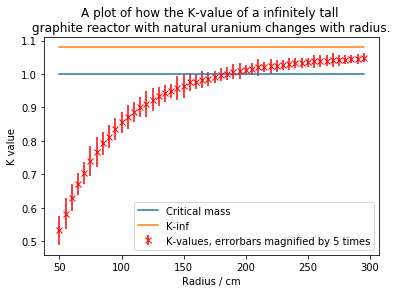

In [ ]:
thirdx = x
thirdy = km
thirdsd = ks

a = [thirdx[0], thirdx[len(thirdx)-1]]
b = [1,1]
c = [v_eff,v_eff]


plt.errorbar(thirdx,thirdy,yerr=thirdsd*5, fmt='rx', label = 'K-values, errorbars magnified by 5 times')
plt.plot(a,b, label = 'Critical mass')
plt.plot(a,c, label = 'K-inf')

plt.title('A plot of how the K-value of a infinitely tall \ngraphite reactor with natural uranium changes with radius.')
plt.xlabel('Radius / cm')
plt.ylabel('K value')
plt.legend()
# plt.savefig('Radius.png', dpi = 600)
plt.show()